In [1]:
import os
import json
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix
from scipy.io import arff

# Set the device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure Polars
pl.Config.set_tbl_rows(-1)


polars.config.Config

In [3]:
# read from directory
train, trameta = arff.loadarff('../../data/GCM_Training.arff')
test, tstmeta = arff.loadarff('../../data/GCM_Test.arff')
train = pl.from_numpy(train)
test = pl.from_numpy(test)
train.shape, test.shape

((144, 16064), (46, 16064))

In [4]:
print(train['class'].cast(pl.Utf8).value_counts().sort('counts', descending=True))
print(test['class'].cast(pl.Utf8).value_counts().sort('counts', descending=True))

shape: (14, 2)
┌───────────────┬────────┐
│ class         ┆ counts │
│ ---           ┆ ---    │
│ str           ┆ u32    │
╞═══════════════╪════════╡
│ Leukemia      ┆ 24     │
│ CNS           ┆ 16     │
│ Lymphoma      ┆ 16     │
│ Pancreas      ┆ 8      │
│ Uterus__Adeno ┆ 8      │
│ Melanoma      ┆ 8      │
│ Prostate      ┆ 8      │
│ Ovary         ┆ 8      │
│ Lung          ┆ 8      │
│ Breast        ┆ 8      │
│ Renal         ┆ 8      │
│ Bladder       ┆ 8      │
│ Mesothelioma  ┆ 8      │
│ Colorectal    ┆ 8      │
└───────────────┴────────┘
shape: (14, 2)
┌───────────────┬────────┐
│ class         ┆ counts │
│ ---           ┆ ---    │
│ str           ┆ u32    │
╞═══════════════╪════════╡
│ Leukemia      ┆ 6      │
│ Lymphoma      ┆ 6      │
│ CNS           ┆ 4      │
│ Colorectal    ┆ 3      │
│ Bladder       ┆ 3      │
│ Mesothelioma  ┆ 3      │
│ Ovary         ┆ 3      │
│ Lung          ┆ 3      │
│ Breast        ┆ 3      │
│ Renal         ┆ 3      │
│ Pancreas      ┆ 3      

In [5]:
# Split into features and labels
X_train = train.select(pl.col('*').exclude('class')).to_pandas()
y_train = train.select(pl.col('class').cast(pl.datatypes.Utf8)).to_pandas()


X_test = test.select(pl.col('*').exclude('class')).to_pandas()
y_test = test.select(pl.col('class').cast(pl.datatypes.Utf8)).to_pandas()

In [6]:
# Convert labels to a list of labels
y_train = [labels.split(',') for labels in y_train['class']]
y_test = [labels.split(',') for labels in y_test['class']]

# One-hot encode the labels
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)


In [7]:
# Define the pipeline with StandardScaler and MLPClassifier
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=100, random_state=1))  # Adjust parameters as needed
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_encoded)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(max_iter=100, random_state=1))])

In [8]:
# Use the pipeline to make predictions on the test set
y_pred = pipeline.predict(X_test)

# Generating classification report
report = classification_report(y_test_encoded, y_pred, target_names=mlb.classes_)

# Print evaluation report
print("Evaluation Report for MLP Classifier with StandardScaler:")
print(report)


Evaluation Report for MLP Classifier with StandardScaler:
               precision    recall  f1-score   support

      Bladder       0.00      0.00      0.00         3
       Breast       0.00      0.00      0.00         3
          CNS       1.00      0.75      0.86         4
   Colorectal       0.40      0.67      0.50         3
     Leukemia       1.00      0.83      0.91         6
         Lung       0.33      0.33      0.33         3
     Lymphoma       0.80      0.67      0.73         6
     Melanoma       1.00      0.50      0.67         2
 Mesothelioma       1.00      1.00      1.00         3
        Ovary       0.50      0.33      0.40         3
     Pancreas       1.00      0.33      0.50         3
     Prostate       0.00      0.00      0.00         2
        Renal       1.00      0.33      0.50         3
Uterus__Adeno       0.00      0.00      0.00         2

    micro avg       0.61      0.48      0.54        46
    macro avg       0.57      0.41      0.46        46
 weig

/home/sebacastillo/.ealab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebacastillo/.ealab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1) Zero Scores for Some Classes (e.g., 'Bladder' and 'Breast')

The fact that classes like 'Bladder' and 'Breast' have zero scores in precision, recall, and F1-score suggests that the classifier is indeed struggling to correctly predict these classes. This could be due to several reasons:

- **Classifier Never Predicts These Classes**: If the classifier never predicts a certain class (in this case, 'Bladder' and 'Breast'), both precision and recall will be zero. Precision is zero because there are no true positives (the denominator in the precision calculation becomes zero), and recall is zero because the classifier fails to identify any actual positives.
- **Class Imbalance**: If these classes have a very small number of instances compared to others, the classifier might struggle to learn enough about them. This is a common issue in imbalanced datasets where the model is biased towards the majority class.
- **Insufficient or Misleading Features**: The features used to train the model might not contain enough information to distinguish these classes effectively, or they might be misleading the model.
- **Overfitting on Other Classes**: The model might be overfitting to more frequent or easier-to-classify classes, at the expense of these challenging ones.

### 2) Maximum Scores for Some Classes (e.g., 'Mesothelioma')

On the other end of the spectrum, some classes like 'Mesothelioma' show very high or perfect scores. This indicates that the classifier performs exceptionally well in predicting these classes. Possible reasons include:

- **Clear Feature Distinctions**: These classes might have very distinct features that are easily recognizable by the model.
- **Sufficient Training Data**: If there's a good amount of representative data for these classes, the model can learn to predict them accurately.
- **Balanced Performance**: The model may not be overly biased towards other classes, allowing it to perform well on these specific classes.

### Additional Insights:

- **Overall Performance Metrics**: The 'micro avg', 'macro avg', and 'weighted avg' scores give an overall picture of the model's performance across all classes. The 'macro avg' is generally lower than the 'micro avg' and 'weighted avg', indicating that the model's performance is not uniformly good across all classes.
- **Influence of Class Imbalance**: The 'weighted avg' takes into account the support (number of true instances) for each class, which can be a more accurate reflection of the model's performance in imbalanced scenarios.

### Steps Forward:

- **Address Class Imbalance**: If your dataset is imbalanced, consider techniques like SMOTE, undersampling, or adjusting class weights in the classifier.
- **Feature Engineering**: Investigate if additional or different features can help improve the model's ability to distinguish the challenging classes.
- **Model Complexity**: Evaluate if the model's architecture is suitable for the complexity of the task. Adjusting layers or neurons in the MLP might yield different results.
- **Cross-Validation**: Use cross-validation to ensure that the model's performance is consistent across different subsets of your data.
- **Error Analysis**: Conduct a detailed error analysis to understand where and why the model is making mistakes, especially for classes with low scores.

Overall Weighted F1 Score: 0.5278279691323169


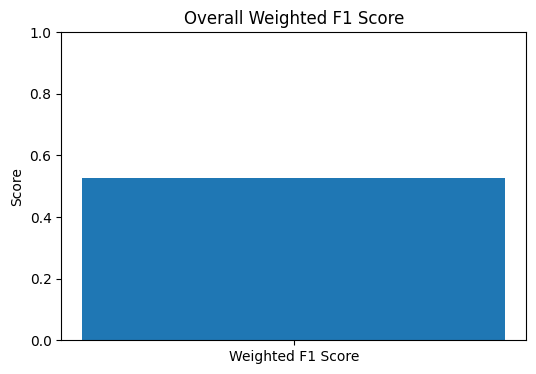

In [9]:
# Calculate the overall weighted F1 score
weighted_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print(f"Overall Weighted F1 Score: {weighted_f1}")

# Plot the overall weighted F1 Score
plt.figure(figsize=(6, 4))
plt.bar(['Weighted F1 Score'], [weighted_f1])
plt.ylim(0, 1)  # F1 score ranges from 0 to 1
plt.ylabel('Score')
plt.title('Overall Weighted F1 Score')
plt.show()


/home/sebacastillo/.ealab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sebacastillo/.ealab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


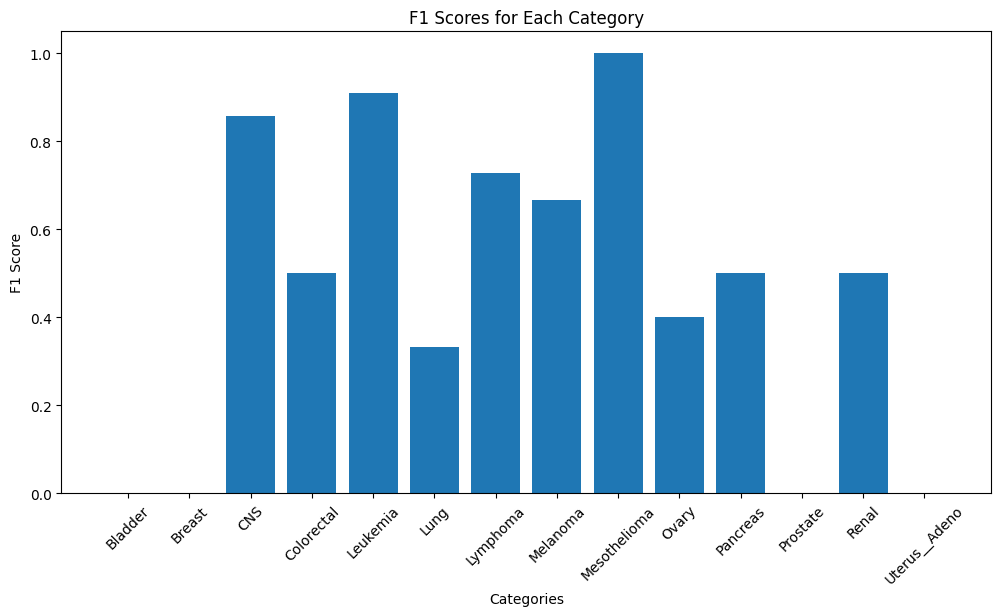

In [10]:
report = classification_report(y_test_encoded, y_pred, target_names=mlb.classes_, output_dict=True)
f1_scores = {label: report[label]['f1-score'] for label in mlb.classes_}
categories = list(f1_scores.keys())
scores = list(f1_scores.values())

plt.figure(figsize=(12, 6))
plt.bar(categories, scores)
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.title('F1 Scores for Each Category')
plt.show()